In [1]:
import pandas as pd
import numpy as np
import pandas_gbq
import os.path
from pandas.io.json import json_normalize
from datetime import datetime
pd.options.display.max_columns = None
import altair as alt
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

In [2]:
query = """

WITH
  max_date AS (
  SELECT
    merchant_id,
    MAX(date) MaxDate,
  FROM
    bharatpe-analytics-prod.bharatpe_mongo_data.merchant_psp_dump
  WHERE
    date>'2018-01-01'
  GROUP BY
    merchant_id )
SELECT
  app.merchant_id,
  app_details
FROM
  bharatpe-analytics-prod.bharatpe_mongo_data.merchant_psp_dump app
JOIN
  max_date
ON
  max_date.merchant_id = app.merchant_id
  AND max_date.MaxDate = app.date
WHERE
  date>'2018-01-01'
  AND app.merchant_id IN (
  SELECT
    merchant_id
  FROM (
    SELECT
      merchant_id
    FROM
      `bharatpe-analytics-prod.bharatpe_data_platfrom.universal_merchant_data_mart`
    WHERE
      DATE(merchant_created_at) >= DATE_SUB(CURRENT_DATE(), INTERVAL 60 DAY) ) )

"""

In [3]:
df = pandas_gbq.read_gbq(query)

Downloading: 100%|██████████| 713690/713690 [01:44<00:00, 6816.62rows/s]


In [4]:
new_merchants = """
WITH
  recent_merchants AS (
  SELECT
    pt.merchant_id,
    COUNT(DISTINCT id) AS txns,
    cast(SUM(amount) as int) AS tpv
  FROM
    bharatpe-analytics-prod.payin.transactions pt
  JOIN
    `bharatpe-analytics-prod.bharatpe_data_platfrom.universal_merchant_data_mart` dm
  ON
    pt.merchant_id = dm.merchant_id
  WHERE
    status = "SUCCESS"
    AND DATE(dm.merchant_created_at) >= DATE_SUB(CURRENT_DATE(), INTERVAL 60 DAY)
    AND DATE(payment_timestamp) >= DATE_SUB(CURRENT_DATE(), INTERVAL 30 DAY)
  GROUP BY
    1
)

select * from recent_merchants

"""

In [5]:
new_merchants = pandas_gbq.read_gbq(new_merchants)

Downloading: 100%|██████████| 568319/568319 [00:10<00:00, 55782.05rows/s]


In [6]:
max_daily_txn = """
WITH
  merchant_list AS (
  SELECT
    merchant_id,
    DATE(merchant_created_at) as onboarding_date
  FROM
    `bharatpe-analytics-prod.bharatpe_data_platfrom.universal_merchant_data_mart`
  WHERE
    DATE(merchant_created_at) >= DATE_SUB(CURRENT_DATE(), INTERVAL 60 DAY)),

  txn_temp AS (
  SELECT
    merchant_id,
    DATE(payment_timestamp) AS payment_date,
    SUM(amount) AS daily_tpv,
    COUNT(DISTINCT id) AS daily_txns,
    CURRENT_DATE() AS today
  FROM
    `bharatpe-analytics-prod.payin.transactions`
  WHERE
    status = "SUCCESS"
    AND merchant_id IN (
    SELECT
      merchant_id
    FROM
      merchant_list )
    group by 1,2)


    select tt.merchant_id,
        MAX(CASE
        WHEN tt.payment_date >= ml.onboarding_date AND tt.payment_date < DATE_SUB(DATE(ml.onboarding_date), INTERVAL -7 DAY) THEN daily_txns
      ELSE
      0
    END
      ) AS w1_max_daily_txns

    from txn_temp tt
    join merchant_list ml
    on tt.merchant_id = ml.merchant_id
    group by 1
    order by 2 desc
"""

In [7]:
max_daily_txn = pandas_gbq.read_gbq(max_daily_txn)

Downloading: 100%|██████████| 730742/730742 [00:09<00:00, 78311.95rows/s]


In [8]:
tickets_full = """
SELECT
  merchant_id,
  subject,
  type,
  count(id) as tickets

FROM
  `bharatpe-analytics-prod.bharatpe_analytics_data.fw_tickets`
WHERE
  DATE(created_at) >= DATE_SUB(CURRENT_DATE(), INTERVAL 60 DAY) 
  and merchant_id is not Null
group by 1,2,3
"""

In [9]:
tickets_full = pandas_gbq.read_gbq(tickets_full)

Downloading: 100%|██████████| 718877/718877 [00:19<00:00, 36887.29rows/s]


In [10]:
tickets= """
with  unresolved as (

SELECT
  merchant_id,
  count(id) as unresolved_tickets

FROM
  `bharatpe-analytics-prod.bharatpe_analytics_data.fw_tickets`
WHERE
  DATE(created_at) >= DATE_SUB(CURRENT_DATE(), INTERVAL 60 DAY) 
  and merchant_id is not Null
  and resolved_at is NULL
  group by 1
),
total as (

select merchant_id, count(id) as total_tickets
FROM
  `bharatpe-analytics-prod.bharatpe_analytics_data.fw_tickets`

WHERE
  DATE(created_at) >= DATE_SUB(CURRENT_DATE(), INTERVAL 60 DAY) 
  and merchant_id is not Null
  group by 1
)

select total.merchant_id, total_tickets, unresolved_tickets,COALESCE(cast(100*unresolved_tickets/total_tickets as int), 0 ) unresolved_percent

from total
left join unresolved
on total.merchant_id = unresolved.merchant_id
"""

In [11]:
tickets = pandas_gbq.read_gbq(tickets)

Downloading: 100%|██████████| 286140/286140 [00:06<00:00, 42166.27rows/s]


In [12]:
c1 = new_merchants['tpv'] >= 500
c2 = new_merchants['txns'] >= 15
c = c1 & c2
new_merchants['Active'] = np.where(c, 1, 0)

In [13]:
act_dic = new_merchants.set_index(['merchant_id'])['Active'].to_dict()

In [14]:
def apps(x): 
    try:
        ev = eval(x[1:-1])
        result = [ev[i]['appName'] for i in range(0,len(ev))]
    except:
        result = []
    return result  

In [15]:
df['app_names'] = df['app_details'].apply(lambda x :apps(x))

In [16]:
d = {}
for item in df['app_names']:
    for el in item:
        if el in d:
            d[el] +=1
        else:
            d[el]=1      

In [17]:
sorted(d.items(), key=lambda x: -x[1])[:7]
# [i[0] for i in  sorted(d.items(), key=lambda x: -x[1])[:100]]

[('BharatPe', 722895),
 ('WhatsApp', 647548),
 ('PhonePe', 562438),
 ('Drive', 468046),
 ('Instagram', 467647),
 ('Truecaller', 450455),
 ('Paytm', 438394)]

In [18]:
tickets_full = tickets_full.merge(tickets, how = 'left', left_on = "merchant_id", right_on = "merchant_id")

In [19]:
tickets_full['Active'] = tickets_full['merchant_id'].map(act_dic)
tickets_full = tickets_full[~tickets_full['Active'].isna()]

tic_act_dic = tickets_full.groupby(['type'])['Active'].mean().to_dict()

vis1 = pd.DataFrame(tickets_full['type'].value_counts()[:30]).reset_index()
vis1.columns = ['Type','Count']
vis1['Activation'] = vis1['Type'].map(tic_act_dic)
alt.themes.enable('fivethirtyeight')
base = alt.Chart(vis1).encode(y=alt.Y('Type:N',axis=alt.Axis(title=""), sort = "-x",stack='normalize'),
                             tooltip = ['Type'])

bar = base.mark_bar(color = 'lightgrey').encode(x=alt.X('Count:Q',axis=alt.Axis(title="Issue Count")))

txt_bar = bar.mark_text(align='right',
        baseline='middle',angle = 0
).encode(
    x=alt.X('Count:Q',axis=alt.Axis(title="",labels=True,ticks=True)),
    text=alt.Text('Count:Q',format='1.0d')
)

(bar + txt_bar).properties(height = 500, width = 400).configure_axis(labelLimit=1000)

alt.LayerChart(...)

In [20]:
final = df.merge(new_merchants, how = 'left', left_on = "merchant_id", right_on = "merchant_id")
final = final.merge(max_daily_txn, how = 'left', left_on = "merchant_id", right_on = "merchant_id")
final = final.merge(tickets, how = 'left', left_on = "merchant_id", right_on = "merchant_id")

In [21]:
final = final[final['merchant_id'].isin(new_merchants['merchant_id'])]   #final[~final['Active'].isna()]

In [22]:
final.shape

(395167, 10)

In [23]:
final['Issue_Raised'] = np.where(final['merchant_id'].isin(tickets['merchant_id']),1,0)

In [24]:
freq_apps = [i[0] for i in  sorted(d.items(), key=lambda x: -x[1])[:100]]

In [25]:
for k in freq_apps:
    final[k] = final['app_names'].apply(lambda x:1*(x.count(k)>0))

In [26]:
d2 = {}
for k in freq_apps[1:]:
    d2[k] = final[final[k]==1]['Active'].mean()

In [27]:
final['Active'].mean()

0.2965100830787996

In [28]:
sorted(d2.items(), key=lambda x: -x[1])[:5]

[('Paytm for Business', 0.4006145119357126),
 ('HDFC Bank', 0.36359576109464453),
 ('Ola', 0.3614317747695374),
 ('nxt', 0.36140370026742347),
 ('Axis Mobile', 0.3610368786745056)]

In [29]:
# ['Paytm for Business','PhonePe Business','Khatabook','WhatsApp\xa0Business','Google Pay for Business','Amazon Pay for Business']
final['num_business_apps'] = final[['Paytm for Business','PhonePe Business','Khatabook']].sum(axis=1)

In [30]:
final.groupby(['num_business_apps'])['Active'].agg(['mean','count'])

,mean,count
num_business_apps,,
0,0.257604,240513
1,0.338452,111035
2,0.400681,38482
3,0.431186,5137


In [31]:
# data = final[['merchant_id','Active','w1_max_daily_txns','num_business_apps']]
# 'WhatsApp\xa0Business'
data = final[['merchant_id','Active','w1_max_daily_txns','Paytm for Business','PhonePe Business','Khatabook',\
              'WhatsApp\xa0Business','Google Pay for Business','Amazon Pay for Business']]

In [32]:
# data['tickets'] = data['tickets'].fillna(0)
data['Active'] = data['Active'].astype('int')

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import plot_confusion_matrix
import pickle

In [34]:
data['Active'].value_counts()

0    277996
1    117171
Name: Active, dtype: int64

In [35]:
y = data['Active']
X = data[['w1_max_daily_txns','Paytm for Business','PhonePe Business','Khatabook',\
              'WhatsApp\xa0Business','Google Pay for Business','Amazon Pay for Business']]

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X,y ,test_size=0.25,stratify=y,shuffle = True)

In [37]:
params={'n_estimators':20,'colsample_bytree': 0.8, 'gamma': 1.5, 'learning_rate': 0.1, 'max_depth': 6 ,'subsample': 1.0}
clf = XGBClassifier(objective="binary:logistic", eval_metric=["auc","error"], use_label_encoder=False, random_state = 0, enable_categorical=True,\
                    tree_method="approx")
clf.set_params(**params)
eval_set = [(X_test, y_test)]
clf.fit(X_train, y_train,eval_set=eval_set,verbose=True)

[0]	validation_0-auc:0.56819	validation_0-error:0.29651
[1]	validation_0-auc:0.56810	validation_0-error:0.29651
[2]	validation_0-auc:0.85333	validation_0-error:0.21103
[3]	validation_0-auc:0.84362	validation_0-error:0.25450
[4]	validation_0-auc:0.83330	validation_0-error:0.26929
[5]	validation_0-auc:0.85555	validation_0-error:0.19658
[6]	validation_0-auc:0.86202	validation_0-error:0.18345
[7]	validation_0-auc:0.86390	validation_0-error:0.17589
[8]	validation_0-auc:0.86494	validation_0-error:0.17515
[9]	validation_0-auc:0.86460	validation_0-error:0.17585
[10]	validation_0-auc:0.86554	validation_0-error:0.17527
[11]	validation_0-auc:0.86607	validation_0-error:0.17459
[12]	validation_0-auc:0.86637	validation_0-error:0.17398
[13]	validation_0-auc:0.86657	validation_0-error:0.17294
[14]	validation_0-auc:0.86682	validation_0-error:0.17294
[15]	validation_0-auc:0.86693	validation_0-error:0.17274
[16]	validation_0-auc:0.86698	validation_0-error:0.17265
[17]	validation_0-auc:0.86710	validation_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric=['auc', 'error'], gamma=1.5, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=20, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, ...)

In [38]:
y_pred = clf.predict(X_test)

In [39]:
pickle.dump(clf, open("active_model", 'wb'))

In [40]:
clf = pickle.load(open("active_model", 'rb'))

In [41]:
roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

0.8670767344071846

In [42]:
d = {}
for thres in range(20,90,5):
    # print(thres/100)
    y_pred = 1*(clf.predict_proba(X_test)[:,1]>thres/100)
    d[thres] = pd.DataFrame([thres/100, sum(y_pred ==1),sum(y_test[y_pred==1]==1)/ sum(y_pred),\
                            sum(y_pred[y_test==1]==1)/sum(y_test==1)],index = ['threshold','predicted_positive','precision','recall']).T

In [43]:
res = pd.concat([d[k] for k in d.keys()], axis = 0).reset_index(drop = True)

In [44]:
c1 = alt.Chart(res, title = "Precision of Positive Class").mark_line(color = 'blue',).encode(
x = 'threshold:Q',
    y = alt.Y('precision:Q')
)

c2 = alt.Chart(res).mark_line(color = 'red').encode(
x = 'threshold',
    y = alt.Y('recall')
)

c3 = alt.Chart(res).mark_bar(color = 'black').encode(
x = 'threshold',
    y = alt.Y('predicted_positive:Q')
)
(c1+c2) | c3

alt.HConcatChart(...)

In [45]:
imp_df = pd.DataFrame({
    "Varname": X_train.columns,
    "Imp": clf.feature_importances_
})
imp_df.sort_values(by="Imp", ascending=False).iloc[:,:]

,Varname,Imp
0,w1_max_daily_txns,0.930437
1,Paytm for Business,0.046508
2,PhonePe Business,0.015646
6,Amazon Pay for Business,0.002109
5,Google Pay for Business,0.001977
4,WhatsApp Business,0.001740
3,Khatabook,0.001583


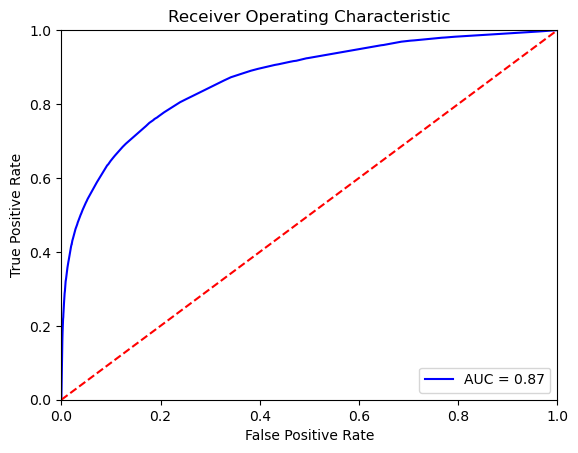

In [46]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification

preds = clf.predict_proba(X_test)[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [47]:
# num_df = data[['merchant_id','w1_max_daily_txns', 'num_business_apps','Active']]
num_df = data[['merchant_id','w1_max_daily_txns','Active','Paytm for Business','PhonePe Business','Khatabook',\
              'WhatsApp\xa0Business','Google Pay for Business','Amazon Pay for Business']]

In [48]:
def num_alt(col):
    bins = [-.01,int(num_df[col].describe()['min']),int(num_df[col].describe()['25%']),int(num_df[col].describe()['50%']),\
           int(num_df[col].describe()['75%']),int(num_df[col].describe()['max'])]

    num_df[col]=pd.cut(x = num_df[col],bins = bins, duplicates = 'drop')
    df = (100*num_df.groupby(col)["Active"].mean()).to_frame().reset_index()
    df[col] = df[col].astype('str')
    df['Count of Merchants'] = list(num_df.groupby(col)["merchant_id"].count())
    
    alt.themes.enable('fivethirtyeight')
    base = alt.Chart(df).encode(x=alt.X(f'{col}:O',axis=alt.Axis(title=""), sort = bins ))

    bar = base.mark_bar(color = 'lightgrey').encode(y=alt.Y('Active:Q',axis=alt.Axis(title="Activation %")))

    line =  base.mark_line(color='aqua').encode(
        y='Count of Merchants:Q'
    )
    txt_bar = bar.mark_text(align='center',
            baseline='middle',
            dy=-6
    ).encode(
        y=alt.Y('Active:Q',axis=alt.Axis(title="",labels=False,ticks=False)),
        text=alt.Text('Active:Q',format='.0f')
    )

    txt_line = line.mark_text(align='center',
            baseline='middle',
            dy=-6, angle = 80, color = 'black'
    ).encode(
        text=alt.Text('Count of Merchants:Q',format='.0f')
    )

    c = (bar + txt_bar+ line +txt_line).resolve_scale(y='independent').properties(width=170, height = 170, title = f"{col}")
    return c

In [49]:
num1 = num_alt('w1_max_daily_txns')

In [50]:
num1.properties(height = 300, width = 500)

alt.LayerChart(...)

In [51]:
data['prob_active'] = clf.predict_proba(data[['w1_max_daily_txns', 'Paytm for Business', 'PhonePe Business',
       'Khatabook', 'WhatsApp\xa0Business', 'Google Pay for Business',
       'Amazon Pay for Business']])[:,1]


In [52]:
data[data['prob_active'] > .9]['Active'].mean()

nan

In [53]:
data[data['prob_active'] > 0]['Active'].mean()

0.2965100830787996

In [54]:
data = data.sample(frac = 1)

In [55]:
data.columns

Index(['merchant_id', 'Active', 'w1_max_daily_txns', 'Paytm for Business',
       'PhonePe Business', 'Khatabook', 'WhatsApp Business',
       'Google Pay for Business', 'Amazon Pay for Business', 'prob_active'],
      dtype='object')

In [56]:
data.rename(columns = {'Paytm for Business':'Paytm_Business','PhonePe Business':'PhonePe_Business','WhatsApp\xa0Business':'Whatsapp_Business',\
                      'Google Pay for Business':'GPay_Business','Amazon Pay for Business':'Amazon_Pay_Business'}, inplace = True)

In [58]:
data.to_gbq("bharatpe_ml_data.new_active_merchants", project_id="bharatpe-analytics-prod",if_exists='replace')

100%|██████████| 1/1 [00:00<00:00, 11949.58it/s]


<AxesSubplot:>

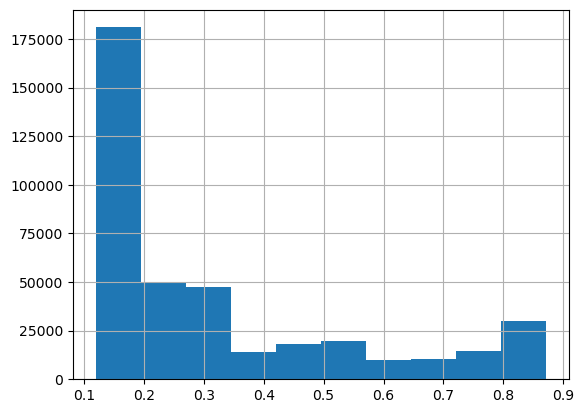

In [60]:
data['prob_active'].hist()

In [61]:
def cat_alt(col):
    df = (100*num_df.groupby(col)["Active"].mean()).to_frame().reset_index()
    df[col] = df[col].astype('str')
    df['Count of Merchants'] = list(num_df.groupby(col)["merchant_id"].count())

    alt.themes.enable('fivethirtyeight')
    base = alt.Chart(df).encode(x=alt.X(f'{col}:O',axis=alt.Axis(title="")))

    bar = base.mark_bar(color = 'lightgrey').encode(y=alt.Y('Active:Q',axis=alt.Axis(title="Activation %")))

    line =  base.mark_line(color='aqua').encode(
        y='Count of Merchants:Q'
    )
    txt_bar = bar.mark_text(align='center',
            baseline='middle',
            dy=-6
    ).encode(
        y=alt.Y('Active:Q',axis=alt.Axis(title="",labels=False,ticks=False)),
        text=alt.Text('Active:Q',format='.0f')
    )

    txt_line = line.mark_text(align='center',
            baseline='middle',
            dy=-6, angle = 80, color = 'black'
    ).encode(
        text=alt.Text('Count of Merchants:Q',format='.0f')
    )

    c = (bar + txt_bar+ line +txt_line).resolve_scale(y='independent').properties(width=170, height = 170, title = f"{col}")

    return c

In [62]:
cat1 = cat_alt('Paytm for Business')
cat2 = cat_alt('PhonePe Business')
cat3 = cat_alt('Khatabook')
cat4 = cat_alt('WhatsApp\xa0Business')
cat5 = cat_alt('Google Pay for Business')
cat6 = cat_alt('Amazon Pay for Business')

In [63]:
(cat1| cat2| cat3) & (cat4| cat5| cat6)

alt.VConcatChart(...)